In [1]:
import pandas as pd
import arff as liacarff

# 加载 ARFF 文件
with open('PROMISE_DOSSPRE_OLD_3.arff', 'r') as f:
    data_dict = liacarff.load(f)

# 提取数据
data = data_dict['data']

# 转换为 DataFrame
df = pd.DataFrame(data, columns=[attr[0] for attr in data_dict['attributes']])
df['ProjectID'] = df['ProjectID'].astype(int)  # 将 ProjectID 列转换为整数类型

# 显示 DataFrame
print(df)

      ProjectID                                    RequirementText _class_
0             1  The system shall refresh the display every 60 ...      PE
1             1  The application shall match the color of the s...      LF
2             1  If projected  the data must be readable.  On a...      US
3             1  The product shall be available during normal b...       A
4             1  If projected  the data must be understandable....      US
...         ...                                                ...     ...
2052          9  The database may trade off fidelity through ca...      FT
2053          9  The API shall have master topology replicating...      FT
2054          9  The system must parse, filter, transform and s...      FT
2055          9  The application shall employ real-user monitor...      FT
2056          9  The software should apply graceful degradation...      FT

[2057 rows x 3 columns]


In [2]:
# DATA PREPROCESSING
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import string

# 下载NLTK的停用词和词性标注器数据
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# lower
df['RequirementText'] = df['RequirementText'].str.lower()

# Remove punctuation, leading and trailing spaces
df['RequirementText'] = df['RequirementText'].apply(lambda x: re.sub(f"[{re.escape(string.punctuation)}]", "", x.strip()))

# 分词
# df['RequirementText'] = df['RequirementText'].apply(word_tokenize)

# stopwords
# stop_words = set(stopwords.words('english'))
# df['RequirementText'] = df['RequirementText'].apply(lambda x: [word for word in x if word not in stop_words])

# stemming
# stemmer = PorterStemmer()
# df['RequirementText'] = df['RequirementText'].apply(lambda x: [stemmer.stem(word) for word in x])

# # lemmatization
# lemmatizer = WordNetLemmatizer()
# df['RequirementText'] = df['RequirementText'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# 合并词语为字符串
# df['RequirementText'] = df['RequirementText'].apply(lambda x: ' '.join(x))

# Replace multiple spaces with a single space
df['RequirementText'] = df['RequirementText'].apply(lambda x: re.sub(' +', ' ', x))

# 移除整个列中每个字符串首尾的全部空格
df['RequirementText'] = df['RequirementText'].str.strip()

# 查看处理后的数据集
print(df.head())

   ProjectID                                    RequirementText _class_
0          1  the system shall refresh the display every 60 ...      PE
1          1  the application shall match the color of the s...      LF
2          1  if projected the data must be readable on a 10...      US
3          1  the product shall be available during normal b...       A
4          1  if projected the data must be understandable o...      US


[nltk_data] Downloading package stopwords to /home/li/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/li/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/li/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [4]:
class_distribution = df['_class_'].value_counts()
print(class_distribution)

_class_
F     444
PE    250
SE    235
US    219
LF    164
MN    162
O     131
A     120
SC     96
L      86
PO     78
FT     72
Name: count, dtype: int64


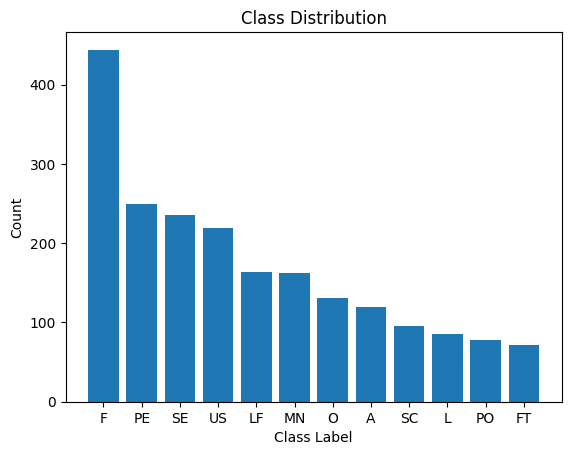

In [5]:
import matplotlib.pyplot as plt

# 获取类别分布
class_distribution = df['_class_'].value_counts()

# 绘制柱状图
plt.bar(class_distribution.index, class_distribution.values)

# 添加标签和标题
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution')

# 显示图表
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
y = df['_class_']
X = df['RequirementText']

# 假设 X 是特征，y 是目标变量（类别标签）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

print(y_test)
class_distribution = y_test.value_counts()
print(class_distribution)

683      F
1175    PO
102      F
831      F
1744    SC
        ..
1157    SE
341      F
753      O
980      A
889      F
Name: _class_, Length: 206, dtype: object
_class_
F     44
PE    25
SE    24
US    22
MN    16
LF    16
O     13
A     12
SC    10
L      9
PO     8
FT     7
Name: count, dtype: int64


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# 使用TfidfVectorizer进行转换
ngram_range = (1,2)
min_df = 0.01 # ignore terms that appear in less than 1% of the documents
max_df = 0.8 # ignore terms that appear in more than 80% of the documents

tfidf_vectorizer = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        norm='l2',
                        sublinear_tf=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 定义Logistic Regression模型
lr_model = LogisticRegression()

# 训练模型
lr_model.fit(X_train_tfidf, y_train)

# 在测试集上进行预测
y_pred = lr_model.predict(X_test_tfidf)

# 输出在测试集上的准确率和分类报告
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy on test set: 67.96%
Classification Report:
               precision    recall  f1-score   support

           A       0.75      0.25      0.38        12
           F       0.61      0.93      0.74        44
          FT       0.67      0.57      0.62         7
           L       1.00      0.33      0.50         9
          LF       0.67      0.88      0.76        16
          MN       0.80      0.75      0.77        16
           O       0.70      0.54      0.61        13
          PE       0.67      0.64      0.65        25
          PO       1.00      0.62      0.77         8
          SC       0.86      0.60      0.71        10
          SE       0.52      0.46      0.49        24
          US       0.78      0.82      0.80        22

    accuracy                           0.68       206
   macro avg       0.75      0.62      0.65       206
weighted avg       0.70      0.68      0.67       206



In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 定义Logistic Regression模型
lr_model = LogisticRegression(solver='liblinear')

# 定义要调优的超参数网格
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

# 创建GridSearchCV对象
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='f1_weighted')

# 执行Grid Search以选择最佳超参数配置
grid_search.fit(X_train_tfidf, y_train)

# 输出最佳超参数配置
print("Best hyperparameters: ", grid_search.best_params_)

# 使用最佳超参数配置的模型进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

# 输出在测试集上的准确率
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set: {:.2f}%".format(accuracy * 100))
print("Classification Report (KNN):\n", classification_report(y_test, y_pred))

Best hyperparameters:  {'C': 10, 'penalty': 'l2'}
Accuracy on test set: 72.33%
Classification Report (KNN):
               precision    recall  f1-score   support

           A       0.78      0.58      0.67        12
           F       0.72      0.89      0.80        44
          FT       0.80      0.57      0.67         7
           L       1.00      0.33      0.50         9
          LF       0.71      0.94      0.81        16
          MN       0.75      0.75      0.75        16
           O       0.73      0.62      0.67        13
          PE       0.72      0.72      0.72        25
          PO       1.00      0.62      0.77         8
          SC       0.75      0.60      0.67        10
          SE       0.59      0.54      0.57        24
          US       0.70      0.86      0.78        22

    accuracy                           0.72       206
   macro avg       0.77      0.67      0.70       206
weighted avg       0.74      0.72      0.71       206



In [9]:
# F binary

df['binary_label'] = df['_class_'].apply(lambda x: 1 if x == 'F' else 0)
X_train, X_test, y_train, y_test = train_test_split(df['RequirementText'], df['binary_label'], test_size=0.2, random_state=42)

# 使用TfidfVectorizer进行转换
ngram_range = (1,2)
min_df = 0.01 # ignore terms that appear in less than 1% of the documents
max_df = 0.8 # ignore terms that appear in more than 80% of the documents

tfidf_vectorizer = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        norm='l2',
                        sublinear_tf=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

print("Accuracy (TF-IDF):", accuracy_score(y_test, y_pred_tfidf))
print("Classification Report (TF-IDF):\n", classification_report(y_test, y_pred_tfidf))

Accuracy (TF-IDF): 0.8932038834951457
Classification Report (TF-IDF):
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       324
           1       0.84      0.61      0.71        88

    accuracy                           0.89       412
   macro avg       0.87      0.79      0.82       412
weighted avg       0.89      0.89      0.89       412



In [10]:
filtered_df = df[df['_class_'] != 'F']
X_train, X_test, y_train, y_test = train_test_split(filtered_df['RequirementText'], filtered_df['_class_'], test_size=0.2, random_state=42, stratify=filtered_df['_class_'])

# 使用TfidfVectorizer进行转换
ngram_range = (1,2)
min_df = 0.01 # ignore terms that appear in less than 1% of the documents
max_df = 0.8 # ignore terms that appear in more than 80% of the documents

tfidf_vectorizer = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        norm='l2',
                        sublinear_tf=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

print("Accuracy (TF-IDF):", accuracy_score(y_test, y_pred_tfidf))
print("Classification Report (TF-IDF):\n", classification_report(y_test, y_pred_tfidf, zero_division=1))

Accuracy (TF-IDF): 0.6501547987616099
Classification Report (TF-IDF):
               precision    recall  f1-score   support

           A       0.72      0.54      0.62        24
          FT       0.82      0.64      0.72        14
           L       0.67      0.12      0.20        17
          LF       0.74      0.79      0.76        33
          MN       0.59      0.48      0.53        33
           O       0.67      0.69      0.68        26
          PE       0.61      0.74      0.67        50
          PO       0.88      0.44      0.58        16
          SC       1.00      0.74      0.85        19
          SE       0.55      0.79      0.65        47
          US       0.60      0.70      0.65        44

    accuracy                           0.65       323
   macro avg       0.71      0.61      0.63       323
weighted avg       0.67      0.65      0.64       323



In [11]:
filtered_df = df[df['_class_'].isin(['MN', 'SC', 'PE'])]
X_train, X_test, y_train, y_test = train_test_split(filtered_df['RequirementText'], filtered_df['_class_'], test_size=0.2, random_state=42, stratify=filtered_df['_class_'])

# 使用TfidfVectorizer进行转换
ngram_range = (1,2)
min_df = 0.01 # ignore terms that appear in less than 1% of the documents
max_df = 0.8 # ignore terms that appear in more than 80% of the documents

tfidf_vectorizer = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        norm='l2',
                        sublinear_tf=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

print("Accuracy (TF-IDF):", accuracy_score(y_test, y_pred_tfidf))
print("Classification Report (TF-IDF):\n", classification_report(y_test, y_pred_tfidf, zero_division=1))

Accuracy (TF-IDF): 0.8627450980392157
Classification Report (TF-IDF):
               precision    recall  f1-score   support

          MN       0.90      0.79      0.84        33
          PE       0.83      0.96      0.89        50
          SC       0.93      0.74      0.82        19

    accuracy                           0.86       102
   macro avg       0.89      0.83      0.85       102
weighted avg       0.87      0.86      0.86       102



In [12]:
filtered_df = df[df['_class_'].isin(['A', 'FT'])]
X_train, X_test, y_train, y_test = train_test_split(filtered_df['RequirementText'], filtered_df['_class_'], test_size=0.2, random_state=42, stratify=filtered_df['_class_'])

# 使用TfidfVectorizer进行转换
ngram_range = (1,2)
min_df = 0.01 # ignore terms that appear in less than 1% of the documents
max_df = 0.8 # ignore terms that appear in more than 80% of the documents

tfidf_vectorizer = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        norm='l2',
                        sublinear_tf=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

print("Accuracy (TF-IDF):", accuracy_score(y_test, y_pred_tfidf))
print("Classification Report (TF-IDF):\n", classification_report(y_test, y_pred_tfidf, zero_division=1))

Accuracy (TF-IDF): 0.8461538461538461
Classification Report (TF-IDF):
               precision    recall  f1-score   support

           A       0.80      1.00      0.89        24
          FT       1.00      0.60      0.75        15

    accuracy                           0.85        39
   macro avg       0.90      0.80      0.82        39
weighted avg       0.88      0.85      0.84        39



In [13]:
filtered_df = df[df['_class_'].isin(['SE', 'L'])]
X_train, X_test, y_train, y_test = train_test_split(filtered_df['RequirementText'], filtered_df['_class_'], test_size=0.2, random_state=42, stratify=filtered_df['_class_'])

# 使用TfidfVectorizer进行转换
ngram_range = (1,2)
min_df = 0.01 # ignore terms that appear in less than 1% of the documents
max_df = 0.8 # ignore terms that appear in more than 80% of the documents

tfidf_vectorizer = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        norm='l2',
                        sublinear_tf=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

print("Accuracy (TF-IDF):", accuracy_score(y_test, y_pred_tfidf))
print("Classification Report (TF-IDF):\n", classification_report(y_test, y_pred_tfidf, zero_division=1))

Accuracy (TF-IDF): 0.8461538461538461
Classification Report (TF-IDF):
               precision    recall  f1-score   support

           L       1.00      0.41      0.58        17
          SE       0.83      1.00      0.91        48

    accuracy                           0.85        65
   macro avg       0.91      0.71      0.74        65
weighted avg       0.87      0.85      0.82        65



In [14]:
filtered_df = df[df['_class_'].isin(['O', 'US'])]
X_train, X_test, y_train, y_test = train_test_split(filtered_df['RequirementText'], filtered_df['_class_'], test_size=0.2, random_state=42, stratify=filtered_df['_class_'])

# 使用TfidfVectorizer进行转换
ngram_range = (1,2)
min_df = 0.01 # ignore terms that appear in less than 1% of the documents
max_df = 0.8 # ignore terms that appear in more than 80% of the documents

tfidf_vectorizer = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        norm='l2',
                        sublinear_tf=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model_tfidf = MultinomialNB()
model_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

print("Accuracy (TF-IDF):", accuracy_score(y_test, y_pred_tfidf))
print("Classification Report (TF-IDF):\n", classification_report(y_test, y_pred_tfidf, zero_division=1))

Accuracy (TF-IDF): 0.9428571428571428
Classification Report (TF-IDF):
               precision    recall  f1-score   support

           O       0.96      0.88      0.92        26
          US       0.93      0.98      0.96        44

    accuracy                           0.94        70
   macro avg       0.95      0.93      0.94        70
weighted avg       0.94      0.94      0.94        70

